<img src="https://fsdl.me/logo-720-dark-horizontal">

# Lab 08: Monitoring

## What You Will Learn

- How to add user feedback and model monitoring to a Gradio-based app
- How to analyze this logged information to uncover and debug model issues
- Just how large the gap between benchmark data and data from users can be, and what to do about it

In [1]:
lab_idx = 8


if "bootstrap" not in locals() or bootstrap.run:
    # path management for Python
    pythonpath, = !echo $PYTHONPATH
    if "." not in pythonpath.split(":"):
        pythonpath = ".:" + pythonpath
        %env PYTHONPATH={pythonpath}
        !echo $PYTHONPATH

    # get both Colab and local notebooks into the same state
    !wget --quiet https://fsdl.me/gist-bootstrap -O bootstrap.py
    import bootstrap
    
    %matplotlib inline

    # change into the lab directory
    bootstrap.change_to_lab_dir(lab_idx=lab_idx)

    bootstrap.run = False  # change to True re-run setup
    
!pwd
%ls

env: PYTHONPATH=.:/env/python
.:/env/python
/content/fsdl-text-recognizer-2022-labs/lab08
api_serverless/  app_gradio/  notebooks/  tasks/  text_recognizer/  training/


### Follow along with a video walkthrough on YouTube:

In [2]:
from IPython.display import IFrame


IFrame(src="https://fsdl.me/2022-lab-08-video-embed", width="100%", height=720)

# Basic user feedback with `gradio`

On top of the basic health check and event logging
necessary for any distributed system
(provided for our application by
[AWS CloudWatch](https://aws.amazon.com/cloudwatch/),
which is collects logs from EC2 and Lambda instances),
ML-powered applications need specialized monitoring solutions.

In particular, we want to give users a way
to report issues or indicate their level of satisfaction
with the model.

The UI-building framework we're using, `gradio`,
comes with user feedback, under the name "flagging".

To see how this works, we first spin up our front end,
pointed at the AWS Lambda backend,
as in
[the previous lab](https://fsdl.me/lab07-colab).

In [3]:
from app_gradio import app


lambda_url = "https://3akxma777p53w57mmdika3sflu0fvazm.lambda-url.us-west-1.on.aws/"

backend = app.PredictorBackend(url=lambda_url)

And adding user feedback collection
is as easy as passing `flagging=True`.

> <small> The `flagging` argument is here being given to
code from the FSDL codebase, `app.make_frontend`,
but you can just pass
`flagging=True` directly
to the `gradio.Interface` class.
In between in our code,
we have a bit of extra logic
so that we can support
multiple different storage backends for logging flagged data.
</small>

Run the cell below to create a frontend
(accessible on a public Gradio URL and inside the notebook)
and observe the new "flagging" buttons underneath the outputs.

In [4]:
frontend = app.make_frontend(fn=backend.run, flagging=True)
frontend.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://28507.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces: https://huggingface.co/spaces


(<gradio.routes.App at 0x7f665fdf64d0>,
 'http://127.0.0.1:7860/',
 'https://28507.gradio.app')

Click one of the buttons to trigger flagging.

It doesn't need to be a legitimate issue with the model's outputs.

Instead of just submitting one of the example images,
you might additionally use the image editor
(pencil button on uploaded images)
to crop it.

Flagged data is stored on the server's local filesystem,
by default in the `flagged/` directory
as a `.csv` file:

In [5]:
!ls flagged

We can load the `.csv` with `pandas`,
the Python library for handling tabular data.

In [6]:
from pathlib import Path

import pandas as pd


log_path = Path("flagged") / "log.csv"

flagged_df = None
if log_path.exists():
    flagged_df = pd.read_csv(log_path, quotechar="'")  # quoting can be painful for natural text data
    flagged_df = flagged_df.dropna(subset=["Handwritten Text"])  # drop any flags without an image

flagged_df

Notice that richer data, like images, is stored with references --
here, the names of local files.

This is a common pattern:
binary data doesn't go in the database,
only pointers to binary data.

We can then read the data back to analyze our model.

In [7]:
from IPython.display import display

from text_recognizer.util import read_image_pil


if flagged_df is not None:
    row = flagged_df.iloc[-1]
    print(row["output"])
    display(read_image_pil(Path("flagged") / row["Handwritten Text"]))

We encourage you to play around with the model for a bit,
uploading your own images.

This is an important step in understanding your model
and your domain --
especially when you're familiar with the data types involved.

But even when you are,
we expect you'll quickly find
that you run out of ideas
for different ways to probe your model.

To really learn more about your model,
you'll need some actual users.

In small projects,
these can be other team members who are less enmeshed
in the details of model development and data munging.

But to create something that can appeal to a broader set of users,
you'll want to collect feedback from your potential userbase.

# Debugging production models with `gantry`

Unfortunately, this aspect of model development
is particularly challenging to replicate in
a course setting, especially a MOOC --
where do these users come from?

As part of the 2022 edition of the course, we've
[been running a text recognizer application](https://fsdl-text-recognizer.ngrok.io)
and collecting user feedback on it.

Rather than saving user feedback data locally,
as with the CSV logger above,
we've been sending that data to
[Gantry](https://gantry.io/),
a model monitoring and continual learning tool.

That's because local logging is a very bad idea:
as logs grow, the storage needs and read/write time grow,
which unduly burdens the frontend server.

The `gradio` library supports logging of user-flagged data
to arbitrary backends via
`FlaggingCallback`s.

So there's some new elements to the codebase:
most importantly here, a `GantryImageToTextLogger`
that inherits from `gradio.FlaggingCallback`.

In [8]:
from app_gradio import flagging


print(flagging.GantryImageToTextLogger.__init__.__doc__)

Logs image-to-text data that was flagged in Gradio to Gantry.

        Images are logged to Amazon Web Services' Simple Storage Service (S3).

        The flagging_dir provided to the Gradio interface is used to set the
        name of the bucket on S3 into which images are logged.

        See the following tutorial by Dan Bader for a quick overview of S3 and the AWS SDK
        for Python, boto3: https://realpython.com/python-boto3-aws-s3/

        See https://gradio.app/docs/#flagging for details on how
        flagging data is handled by Gradio.

        See https://docs.gantry.io for information about logging data to Gantry.

        Parameters
        ----------
        application
            The name of the application on Gantry to which flagged data should be uploaded.
            Gantry validates and monitors data per application.
        version
            The schema version to use during validation by Gantry. If not provided, Gantry
            will use the latest version.

If we add this `Callback` to our setup --
and add a Gantry API key to our environment --
then we can start sending data to Gantry's service.

In [9]:
app.make_frontend??

The short version of how the logging works:
we upload flagged images to S3 for storage (`GantryImageToTextLogger._to_s3`)
and send the URL to Gantry along with the outputs (`GantryImageToTextLogger._to_gantry`).

Below, we'll download that data
and look through it in the notebook,
using typical Python data analysis tools,
like `pandas` and `seaborn`.

By analogy to
[EDA](https://en.wikipedia.org/wiki/Exploratory_data_analysis),
consider this an "exploratory model analysis".

In [10]:
import gantry.query as gq


read_only_key = "VpPfHPDSk9e9KKAgbiHBh7mqF_8"
gq.init(api_key=read_only_key)

gdf = gq.query(  # we query Gantry's service with the following parameters:
    application="fsdl-text-recognizer",  # which tracked application should we draw from?
    tags={"env": "dev"},  # which tags (here, logging environment) should we filter to?
    # what time period should we pull data from? here, the first two months the app was up
    start_time="2022-07-01T07:00:00.000Z",
    end_time="2022-09-01T06:59:00.000Z",
)

raw_df = gdf.fetch()
df = raw_df.dropna(axis="columns", how="all")  # remove any irrelevant columns
print("number of rows:", len(df))
df = df.drop_duplicates(keep="first", subset="inputs.image")  # remove repeated reports, eg of example images
print("number of unique rows:", len(df))

print("\ncolumns:")
df.columns

number of rows: 239
number of unique rows: 64

columns:


Index(['detoxify.obscene(outputs.output_text)', 'env', 'feedback.flag',
       'image.greyscale_image_mean(inputs.image)',
       'image.height(inputs.image)', 'image.width(inputs.image)',
       'inputs.image', 'outputs.output_text',
       'text_stats.basics.entropy(outputs.output_text)',
       'text_stats.basics.n_chars(outputs.output_text)',
       'text_stats.diversity.ttr(outputs.output_text)'],
      dtype='object')

We'll walk through what each of these columns means,
but the three most important are the ones we logged directly from the application:
`flag`s, `input.image`s, and `output_text`.

In [11]:
main_columns = [column for column in df.columns if "(" not in column]  # derived columns have a "function call" in the name
main_columns

['env', 'feedback.flag', 'inputs.image', 'outputs.output_text']

If you're interested in playing
around with the data yourself
in Gantry's UI,
as we do in the
[video walkthrough for the lab](https://fsdl.me/2022-lab-08-video),
you'll need a Gantry account.

Gantry is currently in closed beta.
Unlike training or experiment management,
model monitoring and continual learning
is at the frontier of applied ML,
so tooling is just starting to roll out.

FSDL students are invited to this beta and
[can create a "read-only" account here](https://gantry.io/fsdl-signup)
so they can view the data in the UI
and explore it themselves.

As an early startup,
Gantry is very interested in feedback
from practitioners!
So if you do try out the Gantry UI,
send any impressions, bug reports, or ideas to
`support@gantry.io`

This is also a chance for you
to influence the development
of a new tool that could one day
end up at the center of continual learning
workflows --
as when
[FSDL students in spring 2019 got a chance to be early users of W&B](https://www.youtube.com/watch?t=1468&v=Eiz1zcqrqw0&feature=youtu.be&ab_channel=FullStackDeepLearning).

## Basic stats and behavioral monitoring

We start by just getting some basic statistics.

For example, we can get descriptive statistics for
the information we've logged.

In [12]:
df["feedback.flag"].describe()

count            64
unique            3
top       incorrect
freq             58
Name: feedback.flag, dtype: object

Note that the format we're working with is the `pandas.DataFrame` --
a standard format for tables in Python.

`pandas` can be
[very tricky](https://github.com/chiphuyen/just-pandas-things).

It's not so bad when doing exploratory analysis like this,
but take care when using it in production settings!

If you'd like to learn more `pandas`,
[Brandon Rhodes's `pandas` tutorial from PyCon 2015](https://www.youtube.com/watch?v=5JnMutdy6Fw&ab_channel=PyCon2015)
is still one of the best introductions,
even though it's nearly a decade old.

`pandas` objects support sampling with `.sample`,
which is useful for quick "spot-checking" of data.

In [13]:
df["feedback.flag"].sample(10)

timestamp
2022-08-25 16:49:10.583000+00:00    incorrect
2022-08-16 12:44:00.450000+00:00    incorrect
2022-08-03 19:59:57.720000+00:00    incorrect
2022-08-09 20:34:47.855000+00:00    incorrect
2022-07-29 21:17:14.909000+00:00    incorrect
2022-07-29 03:43:08.309000+00:00    incorrect
2022-08-16 12:46:19.841000+00:00    incorrect
2022-08-03 01:56:24.026000+00:00    incorrect
2022-08-05 23:36:51.565000+00:00    incorrect
2022-07-29 21:17:40.178000+00:00        other
Name: feedback.flag, dtype: category
Categories (4, object): ['incorrect', 'offensive', 'other', 'unusable']

Unlike many other kinds of applications,
toxic and offensive behavior is
one of the most critical potential issues with
many ML models,
from
[generative models like GPT-3](https://www.middlebury.edu/institute/sites/www.middlebury.edu.institute/files/2020-09/gpt3-article.pdf)
to even humble
[image labeling models](https://archive.nytimes.com/bits.blogs.nytimes.com/2015/07/01/google-photos-mistakenly-labels-black-people-gorillas/).

So ML models, especially when newly deployed
or when encountering new user bases,
need careful supervision.

We use a
[Gantry tool called Projections](https://docs.gantry.io/en/stable/guides/projections.html)
to apply the NLP models from the
[`detoxify` suite](https://github.com/unitaryai/detoxify),
which score text for features like obscenity and identity attacks,
to our model's outputs.

To get a quick plot of the resulting values,
we can use the `pandas` built-in interface
to `matplotlib`:

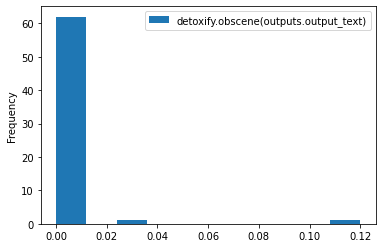

In [14]:
df.plot(y="detoxify.obscene(outputs.output_text)", kind="hist");

Without context, this chart isn't super useful --
is a score of `obscene=0.12` bad?

We need a baseline!

Once the model is stable in production,
we can compare the values across time --
grouping or filtering production data by timestamp.

Here, for this first version of the model,
we compare the results here with the results on the test data,
which was also ingested with `gantry`.

In [15]:
gdf = gq.query(
    application="fsdl-text-recognizer",
    tags={"env": "test"},  # picks out the "test" environment
    start_time="2022-08-12T02:15:00.000Z",
    end_time="2022-08-12T03:00:00.000Z"
)

raw_test_df = gdf.fetch()
test_df = raw_test_df.dropna(axis="columns", how="all")  # remove any irrelevant columns

test_df.sample(10)  # show a sample

,detoxify.identity_attack(feedback.ground_truth_string),detoxify.obscene(feedback.ground_truth_string),detoxify.obscene(outputs.output_text),env,feedback.ground_truth_string,image.greyscale_image_mean(inputs.image),image.height(inputs.image),image.width(inputs.image),inputs.image,outputs.output_text,text_stats.basics.entropy(feedback.ground_truth_string),text_stats.basics.entropy(outputs.output_text),text_stats.basics.n_chars(outputs.output_text),text_stats.diversity.ttr(outputs.output_text)
timestamp,,,,,,,,,,,,,,
2022-08-12 02:47:07.199000+00:00,0.000124,0.000084,0.000194,test,Their air of smiling somnolence showed them to...,14.524897,576.0,640.0,s3://fsdl-text-recognizer-311ccdde42/b283cf357...,Their air of smiling sommolence showed them to...,5.675537,5.537845,326.0,0.722222
2022-08-12 02:48:48.819000+00:00,0.000037,0.000018,0.000029,test,Now Nigel had every right to go where he liked...,10.181508,576.0,640.0,s3://fsdl-text-recognizer-311ccdde42/a0a8f09be...,Now Migel had every right to go where he liked...,5.620574,5.649145,313.0,0.771429
2022-08-12 02:46:10.496000+00:00,0.000040,0.000034,0.001740,test,"""But Eth and me wanted to be at the Youth Host...",12.239548,576.0,640.0,s3://fsdl-text-recognizer-311ccdde42/54fd94b3a...,"""But Clk and me wanted to be at the 'Youth Hos...",5.508871,5.572363,267.0,0.793651
2022-08-12 02:47:24.269000+00:00,0.000100,0.000906,0.000046,test,"""That little beast Robbie Munyard spent six mo...",5.278613,576.0,640.0,s3://fsdl-text-recognizer-311ccdde42/01486d199...,"""That little least Roblic Hunyard spent six mo...",5.701229,5.814846,256.0,0.949153
2022-08-12 02:48:40.451000+00:00,0.042052,0.001215,0.000140,test,No other news except that Elaine is engaged an...,15.958130,576.0,640.0,s3://fsdl-text-recognizer-311ccdde42/46d99a0b4...,No other news except I taime is engaged and go...,5.610173,5.805621,293.0,0.766234
2022-08-12 02:45:21.509000+00:00,0.000043,0.000019,0.000922,test,"When he finally beckoned to them to enter, the...",6.987863,576.0,640.0,s3://fsdl-text-recognizer-311ccdde42/f358786fa...,"When he farclly becloned to them to enter, the...",5.439625,5.471378,265.0,0.762712
2022-08-12 02:47:55.533000+00:00,0.000045,0.000018,0.000020,test,This is the testing time for all. The affair b...,9.173815,576.0,640.0,s3://fsdl-text-recognizer-311ccdde42/1799bf1e8...,This is the testing time for all. The affair b...,5.929307,5.853056,369.0,0.775000
2022-08-12 02:49:10.020000+00:00,0.000039,0.000018,0.000112,test,Thus had they parted the previous evening and ...,6.860246,576.0,640.0,s3://fsdl-text-recognizer-311ccdde42/fe3ba972a...,Thus had they parted the previous evening and ...,5.936408,5.889182,374.0,0.804878
2022-08-12 02:45:42.881000+00:00,0.007105,0.000455,0.009221,test,"Stepping out in their white shorts, they looke...",9.605401,576.0,640.0,s3://fsdl-text-recognizer-311ccdde42/dcf920e04...,"Stepping out in their while shorts, thy cooked...",5.850717,5.846793,334.0,0.845070


To compare the two `DataFrame`s,
we `concat`enate them together
and add in some metadata
identifying where the observations came from.


In [16]:
test_df["environment"] = "test"
df["environment"] = "prod"

comparison_df = pd.concat([df, test_df])

From there, we can use grouping to calculate statistics of interest:

In [17]:
stats = comparison_df.groupby("environment").describe()

stats["detoxify.obscene(outputs.output_text)"]

,count,mean,std,min,25%,50%,75%,max
environment,,,,,,,,
prod,64.0,0.002967,0.015402,0.000015,0.000075,0.000242,0.000803,0.120076
test,232.0,0.003882,0.016203,0.000019,0.000123,0.000639,0.001910,0.171924


These descriptive statistics are helpful,
but as with our simple plot above,
we want to _look_ at the data.

Exploratory data analysis is typically very visual --
the goal is to find phenomena so obvious
that statistical testing is an afterthought --
and so is exploratory model analysis.

`matplotlib` is based on plotting arrays,
rather than `DataFrame`s or other tabular data,
so it's not a great fit on its own here,
unless we want to tolerate a lot of boilerplate.

`pandas` has basic built-in plotting
that interfaces with `matplotlib`,
but it's not that ergonomic for comparisons or flexible
without just dropping back to matplotlib.

There are a number of other Python plotting libraries,
many with an emphasis on share-ability and interaction
([Vega-Altair](https://altair-viz.github.io/),
[`bokeh`](http://bokeh.org/),
and
[Plotly](https://plotly.com/),
to name a few)
and others with an emphasis on usability
(e.g. [`ggplot`](https://realpython.com/ggplot-python/)).

The one that we like for in-notebook analysis
that balances ease of use
on tabular data with flexibility is
[`seaborn`](https://seaborn.pydata.org/).

Comparing the distributions of the `detoxify.obscene` metric
is a single function call:

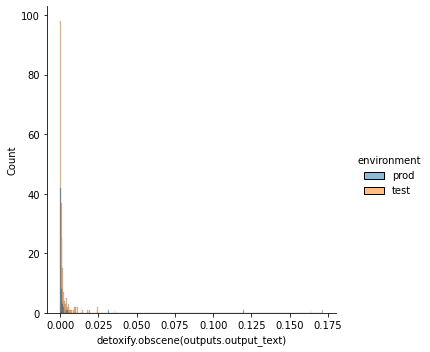

In [18]:
import seaborn as sns


sns.displot(   # plot the dis-tribution
    data=comparison_df,  # of data from this df
    # specifically, this column, along the x-axis
    x="detoxify.obscene(outputs.output_text)",
    # and split it up (in color/hue) by this column
    hue="environment"
);

We can quickly see that the obscenity scores according to `detoxify`
are generally lower in our `prod`uction environment,
so we don't have a reason to suspect
our model is behaving too badly in production
-- though see the exercises for more on this!

We can see the same thing
without having to write query, cleaning, and plotting code
[in the Gantry UI here](https://app.gantry.io/applications/fsdl-text-recognizer/distribution?view=2022-class&compare=test-ingest) --
note that viewing the dashboard requires a Gantry account,
which you can sign up for
[here](https://gantry.io/fsdl-signup).

## Debugging the Text Recognizer

In our application,
we don't have user corrections or labels from annotators,
so we can't calculate an accuracy, a loss, or a character error rate.

We instead look for signals that are correlated with
those values.

This approach has limits
(see, e.g. the analysis in the
[MLDeMon paper](https://arxiv.org/abs/2104.13621))
and setting alerts or test failures on things that are only correlated with,
rather than directly caused by, poor performance is a bad idea.

But it's very useful to have this information logged
to catch large errors at a glance
or to provide tools for slicing, filtering, and grouping data
while doing exploratory model analysis or debugging.

We can also compute these signals with Gantry Projections.

Low entropy (e.g. repetition) is a failure mode of language models,
as is excessively high entropy (e.g. uniformly random text).

We can review the output text entropy distributions in
production and during testing
by plotting them against one another
(here or
[in the Gantry UI](https://app.gantry.io/applications/fsdl-text-recognizer/distribution?view=2022-class&compare=test-ingest)).

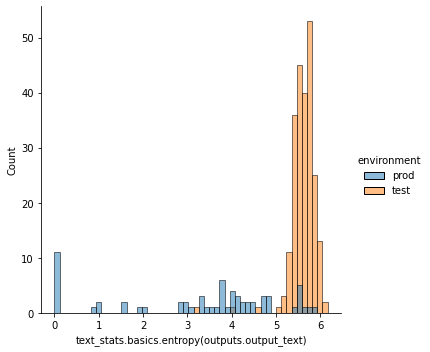

In [19]:
sns.displot(
    data=comparison_df,
    x="text_stats.basics.entropy(outputs.output_text)",
    hue="environment"
);

It appears there are more low-entropy strings in the model's outputs in production.

With models that operate on human-relevant data,
like text and images,
it's important to look at the raw data,
not just projections.

Let's take a look at a sample of outputs from the model running on test data:

In [20]:
test_df["outputs.output_text"].sample(10)

timestamp
2022-08-12 02:47:48.834000+00:00    "Goloe!" he went on earnestly. 'You' are not g...
2022-08-12 02:49:15.478000+00:00    Good-bye, Laudda,' he said
with a deadly funal...
2022-08-12 02:45:56.209000+00:00    And a fine of fuss there was about it, too
thi...
2022-08-12 02:48:09.741000+00:00    "They gives you the wind," said the Sodanster
...
2022-08-12 02:46:24.985000+00:00    "Can't go lighting bonfirer on this bus,"
the ...
2022-08-12 02:49:07.904000+00:00    almost in desperation she appealed, "Will you ...
2022-08-12 02:46:10.496000+00:00    "But Clk and me wanted to be
at the 'Youth Hos...
2022-08-12 02:48:16.980000+00:00    Mr. Copthasme was on dry load in a church at
o...
2022-08-12 02:45:57.320000+00:00    Yes, the bus sut out from Drias. So much
is es...
2022-08-12 02:46:43.159000+00:00    God huck, tir Maushal," sue said gutly. 'Se
&a...
Name: outputs.output_text, dtype: string

The results are not incredible, but they are recognizably "English with typos".

Let's look specifically at low entropy examples from production
(we can also view this
[filtered data in the Gantry UI](https://app.gantry.io/applications/fsdl-text-recognizer/data?view=2022-class-low-entropy&compare=test-ingest)).

In [21]:
df.loc[df["text_stats.basics.entropy(outputs.output_text)"] < 5]["outputs.output_text"].sample(10)

timestamp
2022-08-10 15:42:16.811000+00:00             a by.
a bad a. "Dy we have
a bad by. Mo.
2022-08-10 08:05:29.998000+00:00                                                     
2022-08-03 06:42:58.666000+00:00    maviauanavaiauaiasiay by to
rabiuapuabusiaby b...
2022-08-12 12:46:16.637000+00:00                              # mora."
Rougora." (a).
2022-08-09 20:15:07.906000+00:00                                   Payby
Paysuagramp.
2022-08-19 02:13:27.772000+00:00                                                    #
2022-08-07 18:00:03.964000+00:00    # bey bey bugouply buploy bup
olgodjoysipolusi...
2022-08-08 03:45:05.794000+00:00    bey bey buigavisuabsivagulaby
disajosiasuasiou...
2022-08-21 14:05:41.643000+00:00     told them, 'the police will act.' At five to ten
2022-08-03 01:56:24.026000+00:00                                           bey bey be
Name: outputs.output_text, dtype: string

Yikes! Lots of repetitive gibberish.

Knowing the outputs are bad,
there are two culprits:
the input-output mapping (aka the model)
or the inputs.

We ran the same model in a similar environment
to get those outputs,
so it's most likely due to some difference in the inputs.

Let's check them!

We added Gantry Projections to look at the distribution of pixel values as well.

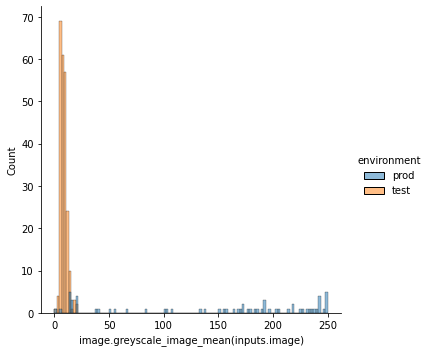

In [22]:
sns.displot(
    data=comparison_df,
    x="image.greyscale_image_mean(inputs.image)",
    hue="environment"
);

There's a huge difference in mean pixel values --
almost all images have mean intensities that are very dark in the testing environment,
but we see both dark and light images in production.

Reviewing the
[raw data in Gantry](https://app.gantry.io/applications/fsdl-text-recognizer/data?view=2022-class-low-entropy&compare=test-ingest)
confirms that we are getting images with very different brightnesses in production
and whiffing the predictions
-- along with images that reveal a number of other interesting failure modes.

To take a look locally,
we'll need to pull the images down from S3,
where they are stored.

The cell below defines a quick utility for
reading from S3 without authentication.

It is based on the `smart_open` and `boto3` libraries,
which we briefly saw in the
[model deployment lab](https://fsdl.me/lab07-colab)
and the
[data annotation lab](https://fsdl.me/lab06-colab).

In [23]:
import boto3
from botocore import UNSIGNED
from botocore.config import Config
import smart_open

from text_recognizer.util import read_image_pil_file

# spin up a client for communicating with s3 without authenticating ("UNSIGNED" activity)
s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))
unsigned_params = {"client": s3}

def read_image_unsigned(image_uri, grayscale=False):
    with smart_open.open(image_uri, "rb", transport_params=unsigned_params) as image_file:
        return read_image_pil_file(image_file, grayscale)

Run the cell below to repeatedly sample a random input/output pair
flagged in production.

image url: s3://fsdl-text-recognizer-311ccdde42/b3dc195e263bb2b567e4b24a7051963781cca175
prediction: #


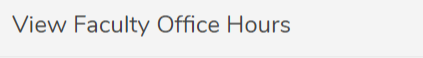

In [24]:
row = df.sample().iloc[0]
print("image url:", row["inputs.image"])
print("prediction:", row["outputs.output_text"])
read_image_unsigned(row["inputs.image"])

### Take-aways for developing models

The most immediate take-away from reviewing just a few examples is that
user data is way more heterogeneous than train/val/test data!

This a
[fairly](https://browsee.io/blog/a-guide-to-session-replays-for-product-managers/)
[universal](https://medium.com/@beasles/edge-case-responsive-design-9b610138ddbd)
[finding](https://quoteinvestigator.com/2021/05/04/no-plan/).

Let's also consider some specific failure modes in our case
and how we might resolve them:

- Failure mode: Users mostly provide images with dark text on light background, but we train on dark background.
  - Resolution: We could check image brightness and flip if needed,
  but this feels like a cop-out -- most text is dark on a light background! 
  - Resolution: We add image brightness inversion to our train-time augmentations.
- Failure mode: Users expect our "handwritten text recognition" tool to work with printed and digital text.
  - Resolution: We could try better sign-posting and user education,
  but this is also something of a cop-out.
  Users expect the tool to work on all text,
  so we shouldn't violate that expectation.
  - Resolution: We synthesize digital text data --
  text rendering is a feature of just about any mature programming language.
- Failure mode: Users provide text on heterogeneous backgrounds
  - Resolution: We collect or synthesize more heterogeneous data,
  e.g. placing text (with or without background coloring)
  on top of random image backgrounds.
- Failure mode: Users provide text with characters and symbols outside of our dictionary.
  - Resolution: We can expand the model outputs and collect more heterogeneous data
- Failure mode: Users provide images with multiple blocks of text
  - Resolution: We develop an architecture/task definition that can handle multiple regions.
  We'll need to collect and/or synthesize data to support

Notice: these are almost entirely changes to data,
and most of them involve collecting more or synthesizing it.

This is very much typical!

Data drives improvements to models,
[even at scale](https://www.lesswrong.com/posts/6Fpvch8RR29qLEWNH/chinchilla-s-wild-implications).

### Take-aways for exploratory model analysis

Notice that we had to write a lot of code,
which was developed and which we ran in a
tight interactive loop.

This type of code is very hard to turn into scripts --
how do you trigger an alert on a plot? --
which makes it brittle and hard to version and share.

It's also based on possibly very large-scale data artifacts.

The right tool for this job is a UI
on top of a database.

In the
[video walkthrough for this lab](https://fsdl.me/2022-lab-08-video),
we do the effectively the same analysis,
but inside Gantry,
which makes the process more fluid.

Gantry is still in closed beta,
but if you're interested in applying it to your own applications, you can
[join the waitlist](https://gantry.io/waitlist/).

# Exercises

### 🌟 Examine the test data strings, both output and ground truth.

We compared our production obscenity metric to the test-time values of that same metric
and determined that we had not gotten worse,
so things were fine.

But what if the test-time baseline is bad?

Review the raw test ground truth data
[here](https://app.gantry.io/applications/fsdl-text-recognizer/data?view=test-ingest),
if you
[signed up a Gantry account](https://gantry.io/fsdl-signup),
or by looking at the contents of `test_df` above.

Sort by `detoxify.identity_attack(feedback.ground_truth_string)`
or filter to only high values of that metric.

Review the example `feedback.ground_truth_string` texts and consider:
is this the subset of English
we want the model to be training on?
what objections might be raised to the contents?

You might also look for cases where the `detoxify` models misunderstood meaning --
e.g. an innocuous use of a word that's often used objectionably.

### 🌟🌟 Start building "regression testing suites" by doing error analysis on these examples.

Do this by going through feedback data one image/text pair at a time --
[in Gantry](https://app.gantry.io/applications/fsdl-text-recognizer/data?view=2022-class-low-entrop)
or inside this notebook.

Start by just taking notes on each example
(anywhere -- Google Sheets/Excel/Notion, or just a sheet of paper).

The primary question you should ask is:
how does this example differ from the data shown in training?

Check
[this W&B Artifact page](https://wandb.ai/cfrye59/fsdl-text-recognizer-2021-training/artifacts/run_table/run-1vrnrd8p-trainpredictions/v194/files/train/predictions.table.json#f5854c9c18f6c24a4e99)
to see what training data
(including augmentation)
looks like.

Once you have some notes,
try and formalize them into a small number of "failure modes" --
you can choose to align them with the failure modes described in the section
on take-aways for model development or not.

If you want to finish the loop,
you might set up Label Studio, as in
[the data annotation lab](https://fsdl.me/lab06-colab).
An annotator should add at least a
"label" that gives the type of issue
and perhaps also add a text annotation
while they are at it.